# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
import random
from dateutil.relativedelta import relativedelta
import os
from itertools import chain, product

In [2]:
from my_functions import merge_basic, scaler, inversed_scale, consolidation_prediction, plot_prediction
from my_functions import preparing_to_predict, plot_metrics

In [3]:
from especial_functions import balance_items_test, get_full_lags, feature_silver, integration_new_features_map
from especial_functions import features_rows_train_silver, get_maps_from, balance_items_test
from especial_functions import augmentation_reduction

In [4]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [5]:
from sklearn.neighbors import KNeighborsClassifier as knnc
from sklearn import metrics

In [6]:
from xgboost import XGBRegressor

In [7]:
import warnings
warnings.filterwarnings('ignore')

### Data

In [8]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [9]:
def exploiting_words(data):
    items_vector = list(data.item_name.unique())
    items_vector = pd.DataFrame({'item_name': items_vector})
    items_vector['lenstr'] = items_vector.item_name.str.len() ## this can be a feature
    items_vector['NWords'] = items_vector.item_name.str.split().str.len()
    items_vector['ItemWord0'] = items_vector.item_name.str.split().str.get(0)
    items_vector['ItemWord_1'] = items_vector.item_name.str.split().str.get(-1)
    
    def my_tokengen(data, columnx):
        unique_words = list()
        for string in  list(data[columnx].values):
            for word in string.split():
                unique_words.append(word)
        unique_words = set(unique_words)
        unique_words = list(unique_words)
        unique_words.sort()
        number = [idx[0] +1 for idx in enumerate(unique_words)]
        map_word = {x:y for x,y in zip(unique_words, number)}

        data[columnx] = data[columnx].map(map_word)
        return data
    
    items_vector = my_tokengen(items_vector, 'ItemWord0')
    items_vector = my_tokengen(items_vector, 'ItemWord_1')
    items_vector = items_vector.merge(data[['item_name','item_id']], on = 'item_name', how = 'left').drop(columns = 'item_name')
    
    return {'item_name_explo':items_vector}

In [10]:
def cleaning_shop_categs(shops, categories):
    shops[['shop_comp1','shop_comp2']] = shops.shop_name.str.split(' "',expand=True,)
    shops['shop_comp1'] = shops.shop_comp1.replace({r'\([^)]*\)' : ''}, regex=True)
    shops['shop_comp1'] = shops['shop_comp1'].str.split(' ').str[0]

    shops['shop_comp2'] = shops.shop_comp2.replace({r'\([^)]*\)' : ''}, regex=True)
    shops['shop_comp2'] = shops.shop_comp2.replace({'"' :''}, regex=True)

    categories[['categ_comp1','categ_comp2']] = categories.item_category_name.str.split(" - ",expand=True,)
    categories['categ_comp1'] = categories.categ_comp1.replace({r'\([^)]*\)' : ''}, regex=True)
    categories['categ_comp2'] = categories.categ_comp2.replace({r'\([^)]*\)' : ''}, regex=True)
    
    return shops, categories

def indexing_shop_categs(data, column):
    my_map = dict()
    for index, value in enumerate(data[column].unique()):
        my_map[value] = index
    data[f'map_{column}'] = data[column].map(my_map)
    return data

<b> Treating the map item, category and shop

In [11]:
items_feature =  exploiting_words(data = items)

In [12]:
shops_feature, categories_feature = cleaning_shop_categs(shops, categories)
shops_feature = indexing_shop_categs(shops_feature, 'shop_comp1')
shops_feature = indexing_shop_categs(shops_feature, 'shop_comp2')
categories_feature = indexing_shop_categs(categories_feature, 'categ_comp1')
categories_feature = indexing_shop_categs(categories_feature, 'categ_comp2')

<b> Fast Cleaning

In [13]:
median = daily_train[(daily_train.shop_id == 32) & (daily_train.item_id == 2973) & (daily_train.date_block_num == 4) & (daily_train.item_price > 0)].item_price.median()
daily_train.loc[daily_train.item_price < 0, 'item_price'] = median

In [14]:
daily_train.loc[daily_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
daily_train.loc[daily_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
daily_train.loc[daily_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [15]:
### test preparation
test_data = test
test_data['date'] = pd.to_datetime(datetime.datetime(2015, 11, 1))
test_data['date_block_num'] = 35
test_data['item_price'] =  np.nan
test_data['item_cnt_day'] = np.nan
test_data = test_data[daily_train.columns]

In [16]:
test_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2015-11-01,35,5,5037,NaN,NaN
1,2015-11-01,35,5,5320,NaN,NaN
2,2015-11-01,35,5,5233,NaN,NaN
3,2015-11-01,35,5,5232,NaN,NaN
4,2015-11-01,35,5,5268,NaN,NaN


In [17]:
daily_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


<b> preparing Train aggregation

In [18]:
def convert_bronze(data, train = False, test_order = 34):
    if train:
        data['date'] = pd.to_datetime(data['date'], format = '%d.%m.%Y')
        
    data['SaleDateMY'] = data['date'].dt.to_period('M').dt.to_timestamp()
    data['item_cnt_day'] = data['item_cnt_day'].clip(0,20)
    
    data = data.groupby(['SaleDateMY', 'date_block_num', 'shop_id', 'item_id'],
                                ).agg( Sale = ('item_cnt_day', 'sum'),
                                   item_price = ('item_price', 'mean'))
    data = data.reset_index().rename(columns = {'SaleDateMY':'Date'})
    
    data['min_date'] = data.groupby(['shop_id', 'item_id'])['Date'].transform('min')

    ### completing with 0 items with 0 in no dates
    
    map_aggg = data[['Date','item_id','shop_id','min_date','Sale']]\
        .pivot_table(index = ['item_id','shop_id','min_date'], columns = ['Date'], values = 'Sale', aggfunc = 'count').reset_index()
    map_aggg = map_aggg.melt(id_vars=['item_id','shop_id','min_date'], value_vars = map_aggg.columns[2:],  var_name='Date', value_name='Nothing')
    map_aggg = map_aggg[map_aggg.Date >= map_aggg.min_date]
    map_aggg = map_aggg[['item_id','shop_id','Date']]
    
    group_data = map_aggg.merge(data, on = ['item_id','shop_id','Date'], how = 'left').fillna(0)
    group_data['Sale'] = group_data['Sale'].clip(0,20)
    
    del map_aggg
    
    if train:
        ### get a map of the dates
        date_list =[group_data.Date.min()]
        date = group_data.Date.min()
        max_date = group_data.Date.max()
        while date <= max_date:
            date = date_list[-1] + relativedelta(months=1)
            date_list.append(date)
        order_list = range(1,len(date_list)+1)
        date_map = pd.DataFrame({'Date':date_list, 'Order':order_list})
        group_data = group_data.merge(date_map, on = 'Date', how = 'left')
    group_data = group_data.drop(columns = ['date_block_num', 'min_date'])
    return group_data

In [19]:
def merge_basic(train_data, items, items_feature ,categories, shops):
    train_merge = train_data.merge(items, on = 'item_id', how = 'left')
    train_merge = train_merge.merge(items_feature, on = 'item_id', how = 'left')
    train_merge = train_merge.merge(categories, on = 'item_category_id', how = 'left')
    train_merge = train_merge.merge(shops, on = 'shop_id', how = 'left')

    return train_merge

In [20]:
daily_train.shape

(2935849, 6)

<b> ghosdata

In [21]:
def get_gost(data, sample = 0.5):
    data_tous = data
    data_tous['shopitem'] = data_tous['shop_id'].astype(str) +'_'+ data_tous['item_id'].astype(str)
    founds = data.shopitem.unique()
    data_tous = data_tous.drop(columns = ['shopitem'])

    cur_shops = data['shop_id'].unique()
    cur_items = data['item_id'].unique()

    full_array =np.array(list(product(*[cur_shops, cur_items])),dtype='int32')

    data_dict = {
        'item_id':full_array[:,1],
        'shop_id':full_array[:,0]
    }
    df = pd.DataFrame(data_dict)
    df['date'] = '01.01.2013'
    df['item_cnt_day'] = 0
    df['item_price'] = 0
    df['date_block_num'] = 0
    df['shopitem'] = df['shop_id'].astype(str) +'_'+ df['item_id'].astype(str)
    df = df[~df.shopitem.isin(founds)]
    
    df = df[daily_train.columns]
    df = df.drop(columns = ['shopitem'])
    return df.sample(frac = sample)

In [22]:
ghost_data = get_gost(data = daily_train, sample = 0.01)

In [23]:
ghost_data.shape

(8241, 6)

In [24]:
train_bronze = convert_bronze(data = daily_train, train = True)

In [25]:
train_bronze.shape

(9784152, 6)

In [26]:
train_merge = merge_basic(train_data = train_bronze, items = items, items_feature = items_feature['item_name_explo'],
                            categories = categories_feature, shops = shops_feature)

In [27]:
train_merge.shape

(9784152, 22)

<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

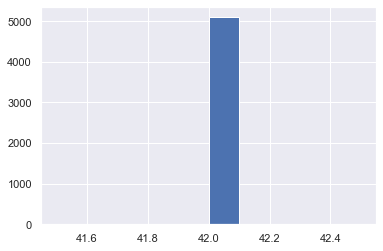

In [28]:
test_data.groupby(['item_id']).agg(lit = ('shop_id','nunique')).reset_index().lit.hist()

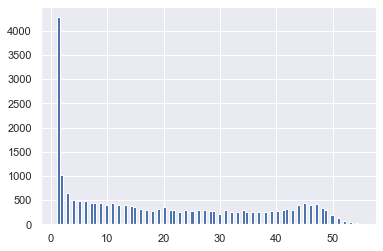

In [29]:
daily_train.groupby(['item_id']).agg(lit = ('shop_id','nunique')).reset_index().lit.hist(bins = 100)

In [30]:
#len(daily_train.item_id.unique()),len(test_data.item_id.unique()), len(test_data.merge(daily_train, on = ['item_id'], how ='inner').item_id.unique())

In [31]:
#len(daily_train.groupby(['shop_id','item_id']).agg(lit = ('item_cnt_day','max')).reset_index()) ,len(test_data),  len(test_data.merge(daily_train, on = ['item_id','shop_id'], how ='inner').item_id.unique())

<b> validation must be some data with historique and some very new data

In [32]:
def supagg(data):
    data['lit'] = data.groupby(['item_id'])['shop_id'].transform('nunique')
    agge = data.groupby(['item_id','shop_id']).agg(lit = ('lit','max')).reset_index()
    return agge

In [33]:
agg_daily_train = supagg(daily_train)

In [34]:
def  reduce_sample(data, frac, single = False ):
    if single:
        data = data.groupby(['item_id','shop_id']).agg(lit = ('lit','max')).reset_index().sample(frac = frac, random_state = 123)
    else:
        data = data.sample(frac = frac, random_state = 123)
        data = data[['item_id','shop_id','lit']]
    return data

In [35]:
vector_drop_1 = reduce_sample(data = agg_daily_train[agg_daily_train.lit > 5], frac = 0.70)
vector_drop_2 = reduce_sample(data = agg_daily_train[agg_daily_train.lit <= 1], frac = 0.40, single = True)

In [36]:
itemshop_to_drop_1 = list(vector_drop_1.assign(shopitem = vector_drop_1.shop_id.astype('str') + '_' + vector_drop_1.item_id.astype('str'))\
                        .shopitem.unique())
itemshop_to_drop_2 = list(vector_drop_2.assign(shopitem = vector_drop_2.shop_id.astype('str') + '_' + vector_drop_2.item_id.astype('str'))\
                        .shopitem.unique())

items_to_drop_all = itemshop_to_drop_1 + itemshop_to_drop_2

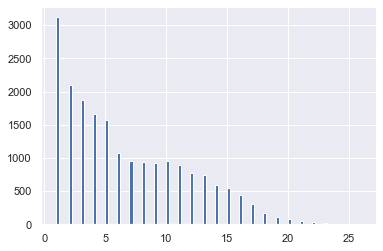

In [37]:
daily_train = daily_train.assign(shopitem = daily_train.shop_id.astype('str') + '_' + daily_train.item_id.astype('str'))

daily_train[ ~daily_train.shopitem.isin(items_to_drop_all) ]\
    .groupby(['item_id']).agg(lit = ('shop_id','nunique')).reset_index().lit.hist(bins = 100)

#### hold-out Train

 almost 95% of the items available

In [38]:
train_bronze.Date.max()

Timestamp('2015-10-01 00:00:00')

In [39]:
test_dates = [datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [40]:
date_val = datetime.datetime(2014, 11, 1)

In [41]:
train_merge = train_merge.assign(shopitem = train_merge.shop_id.astype('str') + '_' + train_merge.item_id.astype('str'))

In [42]:
def get_val_window(data, date, items_to_drop_all):
    val_window_1 = data[data.Date == date ]
    already_found = val_window_1.shopitem.unique()
    
    val_window_2 = data[ (data.Date != date) & (data.shopitem.isin(items_to_drop_all)) ]
    val_window_2['Order'] = val_window_2.groupby(['shop_id','item_id']).cumcount() + 1
    val_window_2 = val_window_2[val_window_2.Order == 1]
    val_window_2['Date'] = date
    val_window_2 = val_window_2[~val_window_2.shopitem.isin(already_found)]
    val_window_2['Sale'] = 0
    print(len(val_window_1),len(val_window_2))
    val_window = pd.concat([val_window_1,val_window_2])
    return val_window

In [43]:
train_full = train_merge[(train_merge.Date < date_val) & (~train_merge.shopitem.isin(items_to_drop_all))]  # itemshop_to_drop_2
val_window = get_val_window(data = train_merge, date = date_val, items_to_drop_all = items_to_drop_all)

349512 46861


In [44]:
train_full.head()

,item_id,shop_id,Date,Sale,item_price,Order,item_name,item_category_id,lenstr,NWords,...,categ_comp1,categ_comp2,map_categ_comp1,map_categ_comp2,shop_name,shop_comp1,shop_comp2,map_shop_comp1,map_shop_comp2,shopitem
0,19,25,2013-01-01,1.0,28.0,1,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,25,3,...,Кино,DVD,11,22,"Москва ТРК ""Атриум""",Москва,Атриум,14,18,25_19
9,28,31,2013-01-01,3.0,549.0,1,"007 Legends [PС, Jewel, русская версия]",30,39,6,...,Игры PC,Стандартные издания,8,14,"Москва ТЦ ""Семеновский""",Москва,Семеновский,14,24,31_28
11,28,46,2013-01-01,1.0,549.0,1,"007 Legends [PС, Jewel, русская версия]",30,39,6,...,Игры PC,Стандартные издания,8,14,"Сергиев Посад ТЦ ""7Я""",Сергиев,7Я,22,36,46_28
14,29,31,2013-01-01,2.0,2499.0,1,"007 Legends [Xbox 360, русская версия]",23,38,6,...,Игры,XBOX 360,5,6,"Москва ТЦ ""Семеновский""",Москва,Семеновский,14,24,31_29
17,32,3,2013-01-01,3.0,349.0,1,1+1,40,3,1,...,Кино,DVD,11,22,"Балашиха ТРК ""Октябрь-Киномир""",Балашиха,Октябрь-Киномир,2,3,3_32


In [45]:
train_full.Date.max(), train_full.Date.min()

(Timestamp('2014-10-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [46]:
train_full.shape, val_window.shape

((1625486, 23), (396373, 23))

### Exploration of the features

<b> knn features

In [47]:
def get_knn_featrue(data):
    train_go = data.assign(SaleBin = np.where(data.Sale > 0 ,1 , 0))
    train_go = train_go[['item_id','shop_id','item_category_id','map_categ_comp1','map_categ_comp2','map_shop_comp1','map_shop_comp2',
                     'ItemWord0','ItemWord_1',
                     'Order','Date', 'SaleBin']]

    def get_full_lags_for_KNN(whole, date_to_take):

        data = whole[ whole.Date < date_to_take]
        data['itemShopMax'] = data.groupby(['shop_id','item_id']).SaleBin.transform('max')
        data['possnumb'] = np.where(data.SaleBin > 0 , 1,0)
        data['possCounts'] = data.groupby(['item_id','shop_id']).possnumb.transform('sum')

        features_dictionary = dict()
        #########################################
        ### only item Columns  ##################
        ########################################

        date_max = data.Date.max()
        date_max = datetime.datetime(date_max.year, date_max.month, date_max.day)

        data['OrderGot'] = data.groupby(['item_id']).Order.transform('min')
        data['SpaceOrder'] = data['Order'] - data['OrderGot']

        #########################################
        ### starts  ##################
        ########################################

        starts = data.groupby('item_id').agg(OrderGot = ('OrderGot','max')).reset_index()

        features_dictionary['Starts'] = {'data':starts, 'keys':['item_id']}


        ####################### ####
        ####### counting ##########
        ############################

        def counting_go(data,variable, column, variable_name, time_feature = 'Date'):
            data_to_use = data
            data_to_use = data_to_use[data_to_use.SaleBin >= 1]
            df_feature = data_to_use.groupby([variable] + [time_feature]).agg(countx = (column,'nunique')).reset_index()
            df_feature = df_feature.rename(columns = {'countx': f'count_unique_{variable_name}'})
            if time_feature == 'Date':
                df_feature[time_feature] = df_feature[time_feature] + pd.DateOffset(months=1)
            else:
                df_feature[time_feature] = df_feature[time_feature] + 1
            del data_to_use
            return  {'data': df_feature, 'keys':[variable,  time_feature]}

        features_dictionary['count shop in item'] = counting_go(data = data,variable = 'shop_id', column = 'item_id', variable_name = 'item')
        features_dictionary['count shop in item'] = counting_go(data = data,variable = 'shop_id', column = 'item_category_id', variable_name = 'categ')
        features_dictionary['count shop in categ1'] = counting_go(data = data,variable = 'shop_id', column = 'map_categ_comp1', variable_name = 'categ1')
        features_dictionary['count shop in categ1'] = counting_go(data = data,variable = 'map_shop_comp2', column = 'map_categ_comp1', variable_name = 'categ1')
        features_dictionary['count shop in categ2'] = counting_go(data = data,variable = 'shop_id', column = 'map_categ_comp2', variable_name = 'categ2')
        features_dictionary['count item in shop'] = counting_go(data = data,variable = 'item_id', column = 'shop_id', variable_name = 'shop_id')

        def counting_total(data, variables,  variable_name, rolling):
            data_to_use = data
            data_to_use = data_to_use[data_to_use.SaleBin >= 1]
            maxDate = data_to_use.Date.max()
            #beginDate = maxDate - relativedelta(months = 12)
            #data_to_use = data_to_use[data_to_use.Date > beginDate]
            df_feature = data_to_use.groupby(variables + ['Date']).agg(countx = ('SaleBin','sum')).reset_index()
            df_feature['rolling_feature'] = df_feature.sort_values('Date').groupby(variables)['countx'].rolling(rolling, min_periods=1).sum().reset_index(level=0, drop=True)
            df_feature['Date'] = df_feature['Date'] + pd.DateOffset(months=1)
            df_feature = df_feature.rename(columns = { 'rolling_feature': f'fullcount_{variable_name}'}).drop(columns = ['countx'])

            return  {'data': df_feature, 'keys':variables + ['Date']}

        features_dictionary['count catego global'] = counting_total(data = data, variables = ['map_categ_comp1'],  variable_name = 'categcomp', rolling = 3)
        features_dictionary['count itemword global'] = counting_total(data = data, variables = ['ItemWord0'],  variable_name = 'itemword0', rolling = 3)

        return features_dictionary

    def integration_new_features_map(data, dict_feature, filter_ceros = True):
        data_wow = data

        ## first merge
        data_wow = data_wow.merge(dict_feature['Starts']['data'], on = dict_feature['Starts']['keys'], how = 'left')

        ### further features
        data_wow['SpaceOrder'] = data_wow['Order'] - data_wow['OrderGot']
        data_wow['SpaceOrder'] = data_wow['SpaceOrder'].fillna(0)

        ## second merge

        for keyx in list(dict_feature.keys())[1:]:
            data_left = dict_feature[keyx]['data']
            onx = dict_feature[keyx]['keys']
            data_wow = data_wow.merge(data_left, on = onx, how = 'left')


        return data_wow.fillna(0)
    
    features_dictionary = get_full_lags_for_KNN(whole = train_go, date_to_take = date_val) ## for train but result easy in val
    full_features_dictionary = {**features_dictionary}
    train_feature = integration_new_features_map(data = train_go, dict_feature = full_features_dictionary)
    
    maxDate = train_feature.Date.max()
    begin = maxDate - relativedelta(months = 5)
    datatrain = train_feature[train_feature.Date >= begin]
    
    def reduction_sampling(data, reduction_0, sample_frac):
        df_reduce = data[data.SaleBin == 0].sample(frac = reduction_0)
        df_keep = data[data.SaleBin == 1]
        df_recons = pd.concat([df_reduce, df_keep])

        df_result = df_recons.sample(frac = sample_frac)
        return df_result

    train_reduced = reduction_sampling(data = datatrain, reduction_0 = 0.60, sample_frac = 0.40)
    
    knn_features = ['count_unique_categ', 'count_unique_categ1', 'count_unique_categ2',
       'count_unique_shop_id', 'fullcount_categcomp', 'fullcount_itemword0']
    knn_target = 'SaleBin'
    
    knn_train_x = train_reduced[knn_features]
    knn_train_y = train_reduced[knn_target]
    
    my_knn = knnc(n_neighbors=6)
    my_knn.fit(knn_train_x, knn_train_y)
    
    result = my_knn.predict_proba(train_feature[knn_features])[:,1]

    return result, my_knn, full_features_dictionary, knn_features 

In [48]:
#preds, knn_machine, featuredict_knn, knn_features = get_knn_featrue(data = train_full)

In [49]:
#train_full['knn_feature'] = preds

In [50]:
def knn_in_validation(data, machine, feature_dict, knn_features):
    full_valandtrain_selected = data
    full_valandtrain_selected['SaleBin'] = np.where(full_valandtrain_selected.Sale >0 , 1 ,0)
    valandtrain_feature = integration_new_features_map(data = full_valandtrain_selected, dict_feature = feature_dict, filter_ceros = False).fillna(0)
    
    X_val = valandtrain_feature[knn_features]
    
    Y_pred = machine.predict_proba(X_val)[:,1]
    return Y_pred

<b> conventional features

In [51]:
def balance_items_test(data, date_to_take , gen_sample = 0.70, seed = 1234, replace_0 = 0.00):
    
    data = data[data.Date < date_to_take]
    data['shopitem'] = data.shop_id.astype('str') + ('_') + data.item_id.astype('str')
    ## for general sample
    to_hide = int( round(len(data.shopitem.unique())*gen_sample,0 ))
    items = list(data.shopitem.unique())
    items = [str(x) for x in items]
    random.seed(seed)
    random.shuffle(items)
    
    keep_items = items[0:to_hide]
    data_result = data[data.shopitem.astype('str').isin(keep_items)].drop(columns = 'shopitem')
    data_result['Sale'] = data_result['Sale'].clip(replace_0, 20)
    
    return data_result

In [52]:
def get_full_lags(whole, date_to_take):
    
    data = whole[ whole.Date < date_to_take]
    data['itemShopMax'] = data.groupby(['shop_id','item_id']).Sale.transform('max')
    data['possnumb'] = np.where(data.Sale > 0 , 1,0)
    data['possCounts'] = data.groupby(['item_id','shop_id']).possnumb.transform('sum')
    
    features_dictionary = dict()
    #########################################
    ### only item Columns  ##################
    ########################################

    date_max = data.Date.max()
    date_max = datetime.datetime(date_max.year, date_max.month, date_max.day)
    
    data['OrderGot'] = data.groupby(['item_id']).Order.transform('min')
    data['SpaceOrder'] = data['Order'] - data['OrderGot']
    
    #########################################
    ### starts  ##################
    ########################################

    starts = data.groupby('item_id').agg(OrderGot = ('OrderGot','max')).reset_index()
    
    features_dictionary['Starts'] = {'data':starts, 'keys':['item_id']}
    
    ####################### ####
    ####### counting ##########
    ############################
    
    def counting_go(data,variable, column, variable_name, time_feature = 'Date'):
        data_to_use = data
        df_feature = data_to_use.groupby([variable] + [time_feature]).agg(countx = (column,'nunique')).reset_index()
        df_feature = df_feature.rename(columns = {'countx': f'count_unique_{variable_name}'})
        if time_feature == 'Date':
            df_feature[time_feature] = df_feature[time_feature] + pd.DateOffset(months=1)
        else:
            df_feature[time_feature] = df_feature[time_feature] + 1
        del data_to_use
        return  {'data': df_feature, 'keys':[variable,  time_feature]}
        
    features_dictionary['count categ2 by shop'] = counting_go(data = data,variable = 'shop_id', column = 'map_categ_comp2', variable_name = 'categ2', time_feature = 'SpaceOrder')
    
    #########################
    #### level  function lags  ######
    #########################
    
    def get_lags_feature_go(data, columns_feature, list_lags, variable_name, category = False, lag_category = None, Null_activator = True, time_feature = 'Date',
                             dimension = 'Sale', operation = 'median'):
            
        data_to_use = data
        data_to_use['SaleL1'] = data_to_use.sort_values('Date').groupby(['item_id','shop_id'])['Sale'].shift(1)
        data_to_use['SaleDiff'] = data_to_use['Sale'] - data_to_use['SaleL1']
        
        sale_min = data_to_use.Sale.min()
        
        if Null_activator:
            data_to_use['Sale'] = np.where(data_to_use['Sale'] == sale_min, np.nan, data_to_use['Sale'])
        else:
            data_to_use['Sale'] = data_to_use['Sale'].fillna(0)
        begin_date = data_to_use.Date.max() - relativedelta(months = 20)
        data_to_use = data_to_use[data_to_use.Date >= begin_date]
        
        df_feature = data_to_use\
            .groupby(columns_feature + [time_feature])\
            .agg( lag = (dimension, operation) )\
            .reset_index()
        
        if time_feature == 'Date':
            df_feature[time_feature] = df_feature[time_feature] + pd.DateOffset(months=1)
        else:
            df_feature[time_feature] = df_feature[time_feature] + 1
        
        for li in list_lags:
            lu = li - 1
            df_feature[f'L{li}_{variable_name}'] = df_feature.sort_values(time_feature).groupby(columns_feature)['lag'].shift(lu)
        df_feature = df_feature.drop(columns = ['lag']).fillna(0)
        
        if category:
            df_feature[f'CategoryL{lag_category}{variable_name}'] = np.where(df_feature[f'L{lag_category}_{variable_name}'] < 2,'A',
                np.where(df_feature[f'L{lag_category}_{variable_name}'] < 5,'B',
                np.where(df_feature[f'L{lag_category}_{variable_name}'] < 10,'C','D')))

        del data_to_use
        
        return {'data':df_feature, 'keys': columns_feature + [time_feature]}
    
    features_dictionary['Focus_meanitem_features'] = get_lags_feature_go(data = data, columns_feature = ['item_id'],  time_feature = 'SpaceOrder',
                                                                list_lags = [1, 4, 8, 12], variable_name = 'meanItem',
                                                                category = True, lag_category = 1)
    
    features_dictionary['Focus_meanCategory_features'] = get_lags_feature_go(data = data, columns_feature = ['item_category_id'], 
                                                                list_lags = [1, 4, 8, 12], variable_name = 'meanCategory')
    
    features_dictionary['Focus_meanshopCategory_features'] = get_lags_feature_go(data = data, columns_feature = ['shop_id', 'item_category_id'],  
                                                                list_lags = [1, 4, 8, 12], variable_name = 'meanshopCategory')
    
    def get_count_integer(data, columns_feature, list_lags, variable_name, Null_activator = True, interval = [0,20], time_feature = 'Date'):
        
        data_to_use = data
        sale_min = data_to_use.Sale.min()
        if Null_activator:
            data_to_use['Sale'] = np.where(data_to_use['Sale'] == sale_min, np.nan, data_to_use['Sale'])
        else:
            data_to_use['Sale'] = data_to_use['Sale'].fillna(0)
        
        data_to_use['integer'] = np.where((data_to_use.SpaceOrder >= 0) & ( (data_to_use.Sale >= interval[0]) & (data_to_use.Sale <= interval[1]) ), 1,0)
        begin_date = data_to_use.Date.max() - relativedelta(months = 18)
        data_to_use = data_to_use[data_to_use.Date >= begin_date]
        
        df_feature = data_to_use\
            .groupby(columns_feature + [time_feature])\
            .agg( integer_count = ('integer','sum') )\
            .reset_index()
        
        if time_feature == 'Date':
            df_feature[time_feature] = df_feature[time_feature] + pd.DateOffset(months=1)
        else:
            df_feature[time_feature] = df_feature[time_feature] + 1
        
        for li in list_lags:
            lu = li - 1
            df_feature[f'L{li}_{variable_name}'] = df_feature.sort_values(time_feature).groupby(columns_feature)['integer_count'].shift(lu)
        df_feature = df_feature.drop(columns = ['integer_count']).fillna(0)

        del data_to_use
        return {'data':df_feature, 'keys': columns_feature + [time_feature]}
    
    features_dictionary['Focus_positive_item']  = get_count_integer(data = data, columns_feature = ['item_id'], interval = [1,20],
                                                                      list_lags = [1,4,8], variable_name = 'positive_item', Null_activator = False)

    ####################
    ### item price #####
    ####################
    
    def item_price_features(data, variables, variable_name, time_feature = 'Date'):
    
        df_feature = data
        if time_feature == 'Date':
            df_feature[time_feature] = df_feature[time_feature] + pd.DateOffset(months=1)
        else:
            df_feature[time_feature] = df_feature[time_feature] + 1
        
        sale_min = df_feature.Sale.min()
        df_feature['Sale'] = np.where(df_feature['Sale'] == sale_min, np.nan, df_feature['Sale'])
        df_feature['avgPrice'] = df_feature.groupby( variables + ['Order']).item_price.transform('mean')
        df_feature['L1Price'] = df_feature.sort_values(time_feature).groupby(['item_id','shop_id'])['item_price'].shift(1)
    
        df_feature = df_feature.groupby( variables + [time_feature]).agg(meanL1Price = ('L1Price','mean')).reset_index()
        df_feature = df_feature.rename(columns = {'meanL1Price': f'{variable_name}_meanL1Price'})
        
        return {'data':df_feature, 'keys': variables + [time_feature]}
        
    #features_dictionary['meanL1Price_item'] = item_price_features(data = data, variables = ['item_id'], variable_name = 'ItemId', time_feature = 'SpaceOrder')
    #features_dictionary['meanL1Price_shopitemWord0'] = item_price_features(data = data, variables = ['shop_id', 'ItemWord0'], variable_name = 'shopid_itemWord0', time_feature = 'SpaceOrder')
    
    def price_median_laggings(data, columns_index, list_lags, variable_name ):
        
        data['mean_price'] = data[data.item_price > 0].groupby( columns_index + ['Date']).item_price.transform('median')
        begin_date = data.Date.max() - relativedelta(months = 18)
        data_to_use = data[data.Date >= begin_date]
        
        df_feature = data_to_use\
            .groupby(columns_index + ['Date'])\
            .agg( lag = ('item_price', 'median') )\
            .reset_index()
        df_feature['Date'] = df_feature['Date'] + pd.DateOffset(months=1)
        
        for li in list_lags:
            lu = li - 1
            df_feature[f'L{li}_{variable_name}'] = df_feature.sort_values('Date').groupby(columns_index)['lag'].shift(lu)
        df_feature = df_feature.drop(columns = ['lag']).fillna(0)
        
        return {'data':df_feature, 'keys': columns_index + ['Date']}
        
    
    #### new feqtures
    features_dictionary['Focus_meanshopcomp2_features'] = get_lags_feature_go(data = data, columns_feature = ['map_shop_comp2'],  
                                                                list_lags = [1, 4, 8, 12], variable_name = 'meanshopcomp2')
    
    features_dictionary['Focus_meanshopcomp_catcomp_features'] = get_lags_feature_go(data = data, columns_feature = ['map_shop_comp1','map_categ_comp1'],  
                                                                list_lags = [1, 4, 8, 12], variable_name = 'meanshopcomp_catcomp')
    #### very new feqtures
    features_dictionary['Focus_sumitem_features'] = get_lags_feature_go(data = data, columns_feature = ['item_id'], 
                                                                list_lags = [1, 4, 8, 12], variable_name = 'sumItem', operation = 'sum')
    
    features_dictionary['Focus_sumshop_features'] = get_lags_feature_go(data = data, columns_feature = ['shop_id'], 
                                                                list_lags = [1, 4, 8, 12], variable_name = 'sumShop', operation = 'sum')
    
    features_dictionary['Focus_sumCatego_features'] = get_lags_feature_go(data = data, columns_feature = ['item_category_id'], 
                                                                list_lags = [1, 4, 8, 12], variable_name = 'sumCatego', operation = 'sum')
    
    features_dictionary['Focus_sumShopCatego_features'] = get_lags_feature_go(data = data, columns_feature = ['shop_id','item_category_id'], 
                                                                list_lags = [1, 4, 8, 12], variable_name = 'sumShopCatego', operation = 'sum')
    
    #features_dictionary['Focus_sumshopcomp1Category_features'] = get_lags_feature_go(data = data, columns_feature = ['map_shop_comp1', 'item_category_id'],  
    #                                                            list_lags = [1, 4, 8, 12], variable_name = 'sumshopcomp1Category', operation = 'sum')
    
    #features_dictionary['Focus_sumshopcomp_catcomp_features'] = get_lags_feature_go(data = data, columns_feature = ['map_shop_comp2','map_categ_comp1'],  
    #                                                            list_lags = [1, 4, 8, 12], variable_name = 'sumshopcomp2_catcomp', operation = 'sum')

    return features_dictionary

In [53]:
def feature_silver(data, date_to_take, Train = True):
    data = data
    
    if Train:
        data = data[ data.Date < date_to_take] 
    else:
        data = data[data.Date >= (date_to_take - relativedelta(months=1))]
    
    ## further quasi id
    data['shop_id_term_5'] =  data['shop_id'].astype('int') % 5
    data['shop_id_term_10'] =  data['shop_id'].astype('int') % 10
    
    data['map1_shop_term_5'] =  data['map_shop_comp1'].astype('int') % 5
    data['map1_shop_term_10'] =  data['map_shop_comp1'].astype('int') % 10
    
    data['map2_shop_term_5'] =  data['map_shop_comp2'].astype('int') % 5
    data['map2_shop_term_10'] =  data['map_shop_comp2'].astype('int') % 10
    
    data['month'] =  data['Date'].dt.month
    
    return data

In [54]:
def integration_new_features_map(data, dict_feature, filter_ceros = True, train = False, dates_back = 18):
    data_wow = data
    
    if train:
        dataMax = data_wow.Date.max()
        beginDate = dataMax - relativedelta(months = dates_back)
        data_wow = data_wow[data_wow.Date >= beginDate]

    ## first merge
    data_wow = data_wow.merge(dict_feature['Starts']['data'], on = dict_feature['Starts']['keys'], how = 'left')
    
    ### further features
    data_wow['SpaceOrder'] = data_wow['Order'] - data_wow['OrderGot']
    data_wow['SpaceOrder'] = data_wow['SpaceOrder'].fillna(0)
    data_wow['SpaceOrder'] = np.where(data_wow['SpaceOrder'].isnull(), 0, data_wow['SpaceOrder'] )
    data_wow['SpaceOrderActivator'] = np.where(data_wow['SpaceOrder'] >= 3,'A' , 'B' ) ### this is q dummy
    
    ## second merge
    
    for keyx in list(dict_feature.keys())[1:]:
        data_left = dict_feature[keyx]['data']
        onx = dict_feature[keyx]['keys']
        data_wow = data_wow.merge(data_left, on = onx, how = 'left')
        
    if filter_ceros:
        data_wow = data_wow[data_wow.SpaceOrder >= 0]
        
    return data_wow.fillna(0)

In [55]:
%%time
train_full_selected = balance_items_test(data = train_full, date_to_take = date_val , gen_sample = 0.9999, seed = 1234)
features_dictionary = get_full_lags(whole = train_full, date_to_take = date_val) ## for train but result easy in val
full_features_dictionary = {**features_dictionary}

Wall time: 42.9 s


In [56]:
%%time
train_feature_tocomplete = feature_silver(train_full_selected , date_to_take = date_val, Train = True) ## for both

Wall time: 847 ms


In [57]:
%%time
train_feature = integration_new_features_map(data = train_feature_tocomplete, dict_feature = full_features_dictionary, train = True)  ## for both not prob

Wall time: 36.3 s


In [58]:
train_feature.shape

(1534849, 73)

In [59]:
def features_rows_train_silver(data, features, target, sample_gen = None, validation = None, dates_back = 18, additional_val_cols = [] ):
    data = data
    if validation:
        if 'shop_id' in additional_val_cols or 'item_id' in additional_val_cols:
            additional_val_cols = []
            
        data_result = data[ data.Date == validation][additional_val_cols +features + [target]]
        features_new = list(data_result.columns)
        features_new.remove(target)
        data_result = data_result[ features_new + [target]].fillna(0)
        
    else:
        dataMax = data.Date.max()
        beginDate = dataMax - relativedelta(months = dates_back)
        data_result = data[data.Date >= beginDate]
            
        data_result = data_result.sample(frac = sample_gen)

    return data_result

In [60]:
train_feature.columns #

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'ItemWord0',
       'ItemWord_1', 'item_category_name', 'categ_comp1', 'categ_comp2',
       'map_categ_comp1', 'map_categ_comp2', 'shop_name', 'shop_comp1',
       'shop_comp2', 'map_shop_comp1', 'map_shop_comp2', 'shop_id_term_5',
       'shop_id_term_10', 'map1_shop_term_5', 'map1_shop_term_10',
       'map2_shop_term_5', 'map2_shop_term_10', 'month', 'OrderGot',
       'SpaceOrder', 'SpaceOrderActivator', 'count_unique_categ2',
       'L1_meanItem', 'L4_meanItem', 'L8_meanItem', 'L12_meanItem',
       'CategoryL1meanItem', 'L1_meanCategory', 'L4_meanCategory',
       'L8_meanCategory', 'L12_meanCategory', 'L1_meanshopCategory',
       'L4_meanshopCategory', 'L8_meanshopCategory', 'L12_meanshopCategory',
       'L1_positive_item', 'L4_positive_item', 'L8_positive_item',
       'L1_meanshopcomp2', 'L4_meanshopcomp2', 'L8_meanshopcomp2',
       'L12_meanshopc

In [61]:
to_drop_columns = ['Date']
ids_columns = ['item_category_id', 'item_id','shop_id',
              'shop_id_term_5','shop_id_term_10', 'map1_shop_term_5',
               'map1_shop_term_10','map2_shop_term_5', 'map2_shop_term_10'] #
strings_number = ['lenstr', 'NWords', 'ItemWord0', 'ItemWord_1', 'map_categ_comp1', 'map_categ_comp2',
                 'map_shop_comp1', 'map_shop_comp2']
numericals = ['month', 'OrderGot',
       'SpaceOrder', 'count_unique_categ2',
       'L1_meanItem', 'L4_meanItem', 'L8_meanItem', 'L12_meanItem',
        'L1_meanCategory', 'L4_meanCategory',
       'L8_meanCategory', 'L12_meanCategory', 'L1_meanshopCategory',
       'L4_meanshopCategory', 'L8_meanshopCategory', 'L12_meanshopCategory',
       'L1_positive_item', 'L4_positive_item', 'L8_positive_item',
       'L1_meanshopcomp2', 'L4_meanshopcomp2', 'L8_meanshopcomp2',
       'L12_meanshopcomp2', 'L1_meanshopcomp_catcomp',
       'L4_meanshopcomp_catcomp', 'L8_meanshopcomp_catcomp',
       'L12_meanshopcomp_catcomp', 'L1_sumItem', 'L4_sumItem', 'L8_sumItem',
       'L12_sumItem', 'L1_sumShop', 'L4_sumShop', 'L8_sumShop', 'L12_sumShop',
       'L1_sumCatego', 'L4_sumCatego', 'L8_sumCatego', 'L12_sumCatego',
       'L1_sumShopCatego', 'L4_sumShopCatego', 'L8_sumShopCatego',
       'L12_sumShopCatego'] + ids_columns + strings_number  #+ ['knn_feature']

categoricals = ['SpaceOrderActivator', 'CategoryL1meanItem']
my_features = to_drop_columns + numericals + categoricals
my_target = 'Sale'
len(my_features) - 3

60

In [62]:
%%time
train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target, sample_gen = 0.60)

Wall time: 3.91 s


In [63]:
train_selection.shape

(920909, 73)

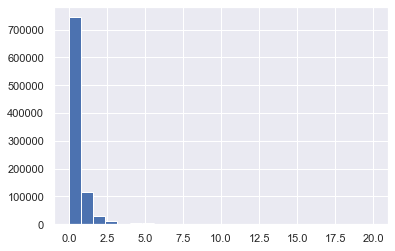

In [64]:
train_selection.Sale.hist(bins = 25)

In [65]:
def augmentation_reduction(data, fracs = [0.7, 0.1, 0.1, 0.8]):
    data_wow = data
    random.seed(1256)
    mins_sale = data_wow.Sale.min()
    zeros = np.array(data_wow[data_wow.Sale == mins_sale].index)
    nx = int(round(zeros.shape[0]*fracs[0], 0))
    indexes = np.random.choice(zeros.shape[0], nx, replace=False)
    zeros_selected = zeros[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(zeros_selected)]
    
    ones = np.array(data_wow[data_wow.Sale == 1].index)
    nx = int(round(ones.shape[0]*fracs[1], 0))
    indexes = np.random.choice(ones.shape[0], nx, replace=False)
    ones_selected = ones[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(ones_selected)]
    
    twoes = np.array(data_wow[data_wow.Sale == 2].index)
    nx = int(round(twoes.shape[0]*fracs[2], 0))
    indexes = np.random.choice(twoes.shape[0], nx, replace=False)
    twoes_selected = twoes[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(twoes_selected)]
    
    twenties = np.array(data_wow[data_wow.Sale == 20].index)
    nx = int(round(twenties.shape[0]*fracs[3], 0))
    indexes = np.random.choice(twenties.shape[0], nx, replace=False)
    twenties_selected = twenties[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(twenties_selected)]
    
    #data_augmented_tens = data_wow[data_wow.Sale > 10]
    data_augmented = pd.concat([data_wow, 
                               ],axis= 0).reset_index()
    
    return data_augmented

In [66]:
zero_vector = [0.05, 0.0001, 0.0001, 0.75]

In [67]:
train_augmented = augmentation_reduction(train_selection, fracs = zero_vector)

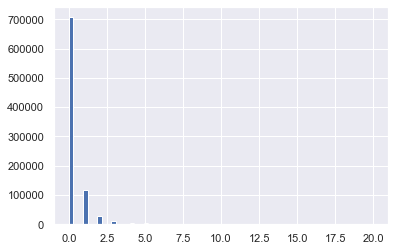

In [68]:
train_augmented.Sale.hist(bins = 65)

### continue ...

In [69]:
def scaler(dataset, features, target, scaler=None, drop_columns = []):
    if scaler:
        features = [x for x in features if x not in drop_columns]
        df = dataset[features + [target]]
        df_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(df_scaled, columns = df.columns, index = df.index)
        return dataset_scaled
    
    else:
        features = [x for x in features if x not in drop_columns]
        df  = dataset[features + [target]]
        scaler = MinMaxScaler()
        scaler.fit(df)

        dataset_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(dataset_scaled, columns = df.columns, index = df.index)
        return dataset_scaled, scaler

In [70]:
my_columns_to_drops = ['shop_id_ItemWord0_mean_LastOrder', 'NWords','L1_iter_count_unique_item_id_shop_id', 'L1_iter_item_shop','SpaceOrder',  
    'shop_id_mean_LastSpaceOrder','count_unique_categ2','map_shop_comp1_mean_LastOrder','ItemWord0_meanL1Price',
    'fullcount_itemword_shop','ItemId_meanL1Price',
    'count_unique_item', 'count_unique_categ1', 'count_unique_shop_id',
    'OrderGot',
    'map2_shop_term_10','map2_shop_term_5', 'map1_shop_term_10', 'map1_shop_term_5',
    ## new drops
    'shop_id_term_10', 'shop_id_term_5','ItemWord_1','map_categ_comp2','map_shop_comp1','ItemWord0',
    'knn_feature', 'lenstr','map_categ_comp1','item_category_id','map_shop_comp2',
    'L1_meanshopcomp2','L4_meanshopcomp2','L8_meanshopcomp2','L12_meanshopcomp2',
    'L1_meanCategory', 'L4_meanCategory','L8_meanCategory','L12_meanCategory'
    ] + \
    ['CategoryL1meanItem_D', 'CategoryL1meanItem_C','CategoryL1meanItem_0','SpaceOrderActivator_A', 'SpaceOrderActivator_B', 'CategoryL1meanItem_B', 'CategoryL1meanItem_A'] 

In [71]:
feature_dictionary = {'numericals':numericals,
                     'categoricals': categoricals,
                     'my_target':my_target,
                      'features_to_drop': my_columns_to_drops}

In [72]:
train_scaled, my_scaler = scaler(train_augmented, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
#train_scaled = train_augmented[ numericals + [my_target] ]
if len(categoricals) != 0:
    train_dummies = pd.get_dummies(train_augmented[categoricals])
    train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)

In [73]:
if len(categoricals) != 0:
    final_features = list(train_dummies.columns) +  numericals
else:
    final_features = numericals
final_features = [x for x in final_features if x not in my_columns_to_drops]

In [74]:
pd.DataFrame({'final_features':final_features}).to_csv('FinalFeatures.csv')

In [75]:
train_scaled.shape, train_selection.shape

((882662, 42), (920909, 73))

In [76]:
sample_frac = 0.25
train_scaled_sampled = train_scaled.sample(frac = sample_frac, random_state = 12489)
train_scaled_sampled[train_scaled_sampled.select_dtypes(np.float64).columns] = train_scaled_sampled.select_dtypes(np.float64).astype(np.float32)

In [77]:
train_scaled_sampled.shape

(220666, 42)

### ML modeling using ADAboost

In [78]:
X_train = train_scaled_sampled[final_features]
Y_train = train_scaled_sampled[my_target]

In [79]:
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 25, min_samples_split = 7, min_samples_leaf = 7 , max_features = 20)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators= 60, learning_rate=0.00001, loss='linear')

In [80]:
%%time
my_ABM.fit(X_train, Y_train)

Wall time: 5min 5s


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                       max_features=20,
                                                       min_samples_leaf=7,
                                                       min_samples_split=7),
                  learning_rate=1e-05, n_estimators=60)

<b> hold out validation

In [81]:
full_valandtrain_selected = val_window

# knn feature for validation
#val_preds = knn_in_validation(data = full_valandtrain_selected, machine = knn_machine, feature_dict = featuredict_knn, knn_features = knn_features)
#full_valandtrain_selected['knn_feature'] = val_preds

In [82]:
full_valandtrain_selected.shape

(396373, 23)

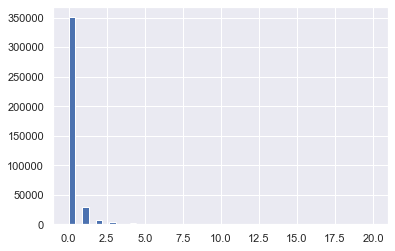

In [83]:
full_valandtrain_selected.Sale.hist(bins = 45)

In [84]:
valandtrain_feature = feature_silver(full_valandtrain_selected, date_to_take = date_val, Train = False)
valandtrain_feature = integration_new_features_map(data = valandtrain_feature, dict_feature = full_features_dictionary, filter_ceros = False).fillna(0)

In [85]:
val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, validation = date_val, additional_val_cols = ['shop_id','item_id']) 

In [86]:
val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )
#val_scaled = val_selection[numericals + [my_target]]
if len(categoricals) != 0:
    val_dummies = pd.get_dummies(val_selection[categoricals])
    val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
else:
    val_scaled_full = val_scaled

In [87]:
X_val = val_scaled_full[final_features]

In [88]:
Y_pred = my_ABM.predict(X_val)

In [89]:
predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)
#predicted_val['Sale'] = Y_pred

In [90]:
my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.Sale.values)

In [91]:
my_lm_plot.shape , my_lm_plot.PredSale.min(), my_lm_plot.PredSale.max()

((396373, 5), 0.0, 17.777777910232544)

In [92]:
my_lm_plot = my_lm_plot.assign(shopitem = my_lm_plot.shop_id.astype('str') + '_' + my_lm_plot.item_id.astype('str'))

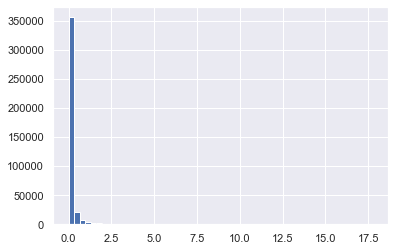

In [93]:
my_lm_plot.PredSale.hist(bins = 55)

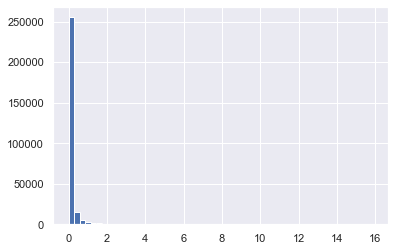

In [94]:
my_lm_plot[ (my_lm_plot.shopitem.isin(items_to_drop_all))].PredSale.hist(bins = 55)
#plt.axhline(x=1, color='r', linestyle='-')

In [95]:
mean_squared_error(my_lm_plot.Sale, my_lm_plot.PredSale) ** (1/2), \
mean_squared_error(my_lm_plot[ (my_lm_plot.shopitem.isin(items_to_drop_all))].Sale, my_lm_plot[ (my_lm_plot.shopitem.isin(items_to_drop_all))].PredSale) ** (1/2)

## full 1.0754162493794321, the dropones 1.1469303214159647 before 1.06
## full 1.07709115865644, the dropones 1.07709115865644 got 1.06

(1.0679288332945482, 1.0700667555851018)

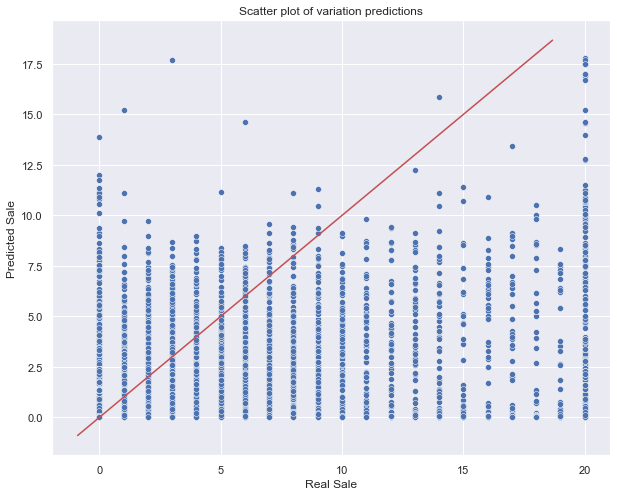

In [96]:
plot_prediction(my_lm_plot)

[Text(0.5, 1.0, 'feature importance')]

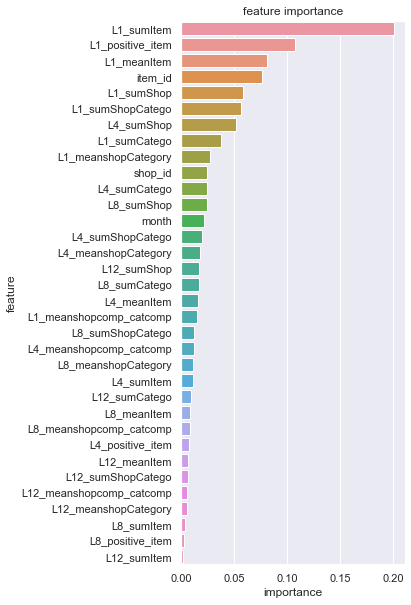

In [97]:
dfplot = pd.DataFrame({'feature':final_features,'importance': list(my_ABM.feature_importances_)}).sort_values('importance',ascending = False)

fig = plt.figure(figsize=(4,10))
ax = sns.barplot(x="importance", y="feature", data=dfplot)
ax.set(title='feature importance')

In [98]:
dfplot.sort_values('importance',ascending = False).head(100).feature.values   # 'L1_meanCategory', 'L4_meanCategory','L8_meanCategory','L12_meanCategory'

array(['L1_sumItem', 'L1_positive_item', 'L1_meanItem', 'item_id',
       'L1_sumShop', 'L1_sumShopCatego', 'L4_sumShop', 'L1_sumCatego',
       'L1_meanshopCategory', 'shop_id', 'L4_sumCatego', 'L8_sumShop',
       'month', 'L4_sumShopCatego', 'L4_meanshopCategory', 'L12_sumShop',
       'L8_sumCatego', 'L4_meanItem', 'L1_meanshopcomp_catcomp',
       'L8_sumShopCatego', 'L4_meanshopcomp_catcomp',
       'L8_meanshopCategory', 'L4_sumItem', 'L12_sumCatego',
       'L8_meanItem', 'L8_meanshopcomp_catcomp', 'L4_positive_item',
       'L12_meanItem', 'L12_sumShopCatego', 'L12_meanshopcomp_catcomp',
       'L12_meanshopCategory', 'L8_sumItem', 'L8_positive_item',
       'L12_sumItem'], dtype=object)

In [137]:
my_vars_checkpoint = ['L1_sumItem', 'L1_meanItem', 'item_id', 'L1_sumShop', 'L4_sumShop',
       'L1_meanshopCategory', 'L8_sumShop', 'L4_meanItem', 'L4_sumItem',
       'shop_id', 'L4_meanshopCategory', 'L1_sumCatego',
       'item_category_id', 'map_shop_comp2', 'L1_positives_categ',
       'L2_positives_categ', 'month', 'L4_sumCatego',
       'L1_meanshopcomp_catcomp', 'L4_positives_categ',
       'L8_meanshopCategory', 'L12_sumShop', 'L4_meanshopcomp_catcomp',
       'L8_sumCatego', 'map_categ_comp1', 'L8_meanItem',
       'L8_meanshopcomp_catcomp', 'L1_meanCategory', 'L1_meanshopcomp2',
       'L12_sumCatego', 'L4_meanshopcomp2', 'L12_meanItem',
       'L8_meanCategory', 'L12_meanshopCategory', 'L8_meanshopcomp2',
       'L12_meanCategory', 'L12_meanshopcomp_catcomp', 'L4_meanCategory',
       'L12_meanshopcomp2', 'L8_sumItem', 'L12_sumItem']

#### Tuning

In [100]:
my_adab_models = [my_ABM]
number_of_machines = 2
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [20, 15,],
    'min_samples_split':[10, 10, ],
    'min_samples_leaf':[10, 8, ],
    'max_features':[20, 25, ],
              
    'n_estimators' : [70, 80, ],
    'learning_rate' : [0.00001, 0.00001, ] }

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    
    n_estimators_param = parameters['n_estimators'][i]
    learning_rate_param = parameters['learning_rate'][i]
    
    my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = max_depth_param, min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param , max_features = max_features_param)
    my_adab = AdaBoostRegressor(base_estimator = my_base, n_estimators = n_estimators_param, learning_rate = learning_rate_param, loss='linear')
    my_adab_models.append(my_adab)
    
machines_labels = machines_labels + ['machine-'+ str(number_of_machines + 1)]

parameters_df = pd.DataFrame(parameters)  

In [101]:
experiments = 5

dict_results = {
    'epoc':list(),
    'machine': list(),
    'error full': list(),
    'error hide': list()
}

for (machine, machine_number) in zip(my_adab_models, machines_labels):
    for epoc in range(0,experiments):
        sample_frac = 0.05
        train_scaled_sampled = train_scaled.sample(frac = sample_frac, random_state = 12489)

        X_train = train_scaled_sampled[final_features]
        Y_train = train_scaled_sampled[my_target]

        machine.fit(X_train, Y_train)

        X_val = val_scaled_full[final_features]
        Y_pred = machine.predict(X_val)
        predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)
        my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.Sale.values)
        my_lm_plot = my_lm_plot.assign(shopitem = my_lm_plot.shop_id.astype('str') + '_' + my_lm_plot.item_id.astype('str'))

        error_full = mean_squared_error(my_lm_plot.Sale, my_lm_plot.PredSale) ** (1/2)
        error_hide = mean_squared_error(my_lm_plot[ (my_lm_plot.shopitem.isin(items_to_drop_all))].Sale, my_lm_plot[ (my_lm_plot.shopitem.isin(items_to_drop_all))].PredSale) ** (1/2)
        
        dict_results['epoc'].append(epoc)
        dict_results['machine'].append(machine_number)
        dict_results['error full'].append(error_full)
        dict_results['error hide'].append(error_hide)
    
tunning_dfresult = pd.DataFrame(dict_results)

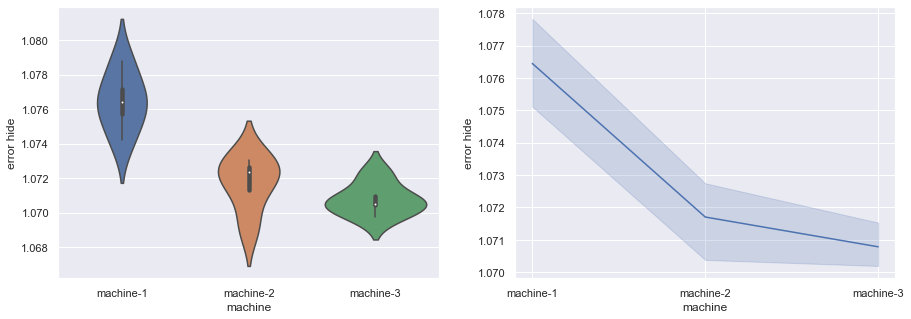

In [102]:
fig, axs = plt.subplots(1,2, figsize=(15,5) )
ax = sns.violinplot(ax = axs[0],x="machine", y="error hide", data=tunning_dfresult)
ax = sns.lineplot(ax = axs[1],x="machine", y="error hide", data=tunning_dfresult)

In [161]:
xgbr = XGBRegressor(n_estimators=400, max_depth=25, eta=0.01, subsample=0.4, colsample_bytree=0.5)

In [162]:
machines = [my_ABM, xgbr]
labels = [f'machine-{x}' for x in range(len(machines))]

In [163]:
experiments = 2

dict_results = {
    'epoc':list(),
    'machine': list(),
    'error full': list(),
    'error hide': list()
}

for (machine, machine_number) in zip(machines[1:], labels[1:]):
    for epoc in range(0,experiments):
        sample_frac = 0.05
        train_scaled_sampled = train_scaled.sample(frac = sample_frac)

        X_train = train_scaled_sampled[final_features]
        Y_train = train_scaled_sampled[my_target]

        machine.fit(X_train, Y_train)

        X_val = val_scaled_full[final_features]
        Y_pred = machine.predict(X_val)
        predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)
        my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.Sale.values)
        my_lm_plot = my_lm_plot.assign(shopitem = my_lm_plot.shop_id.astype('str') + '_' + my_lm_plot.item_id.astype('str'))

        error_full = mean_squared_error(my_lm_plot.Sale, my_lm_plot.PredSale) ** (1/2)
        error_hide = mean_squared_error(my_lm_plot[ (my_lm_plot.shopitem.isin(items_to_drop_all))].Sale, my_lm_plot[ (my_lm_plot.shopitem.isin(items_to_drop_all))].PredSale) ** (1/2)
        
        dict_results['epoc'].append(epoc)
        dict_results['machine'].append(machine_number)
        dict_results['error full'].append(error_full)
        dict_results['error hide'].append(error_hide)
    
tunning_dfresult = pd.DataFrame(dict_results)

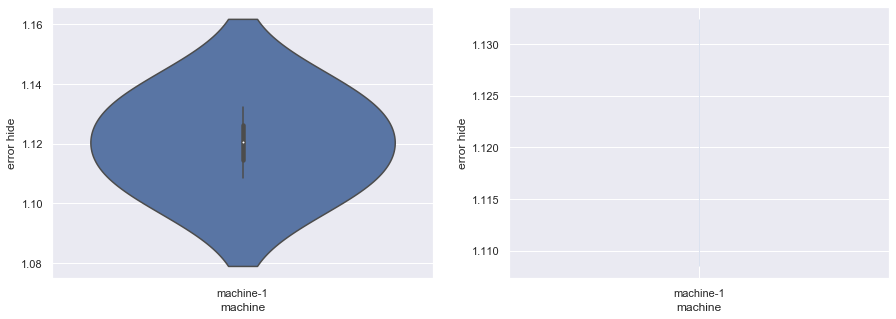

In [164]:
fig, axs = plt.subplots(1,2, figsize=(15,5) )
ax = sns.violinplot(ax = axs[0],x="machine", y="error hide", data=tunning_dfresult)
ax = sns.lineplot(ax = axs[1],x="machine", y="error hide", data=tunning_dfresult)

### Production of folds for cross validation

In [151]:
def get_splited_data(dates_vector):
    train_data = dict()
    validation_data = dict()
    
    for datex in dates_vector:
        datex_str = datex.strftime('%Y-%m-%d')
        train_selection = pd.read_csv(f'generated_datasets/data_{datex_str}/train_selection.csv')
        val_selection = pd.read_csv(f'generated_datasets/data_{datex_str}/val_selection.csv')
        
        train_data[datex_str] = train_selection
        validation_data[datex_str] = val_selection
        print(datex_str)
    return { 'Train Data' : train_data, 
            'Validation Data': validation_data}

In [ ]:
def My_ML_prediction_on_test( data_dict , dates_vector, model, features_dict, zero_vector, frac = 0.80):
    
    numericals = features_dict['numericals']
    categoricals = features_dict['categoricals']
    my_columns_to_drops = features_dict['features_to_drop']
    my_target = features_dict['my_target']
    
    data_result = list()

    for datex in dates_vector:
        datex_str = datex.strftime('%Y-%m-%d')
        #### reading files
        train_selection = data_dict['Train Data'][datex_str]
        val_selection = data_dict['Validation Data'][datex_str]
        train_augmented = augmentation_reduction(train_selection, fracs = zero_vector)
        
        train_scaled, my_scaler = scaler(train_augmented, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
        #train_scaled = train_augmented[ numericals + [my_target] ]
        if len(categoricals) != 0:
            train_dummies = pd.get_dummies(train_augmented[categoricals])
            train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)
            
        if len(categoricals) != 0:
            final_features = list(train_dummies.columns) +  numericals
        else:
            final_features = numericals
        final_features = [x for x in final_features if x not in my_columns_to_drops]
        
        train_scaled_sampled = train_scaled.sample(frac = frac, random_state = 12489)
        
        ### ML train
        X_train = train_scaled_sampled[final_features]
        Y_train = train_scaled_sampled[my_target]
        model.fit(X_train, Y_train)
        
        ### Test data prepa
        val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )
        
        if len(categoricals) != 0:
            val_dummies = pd.get_dummies(val_selection[categoricals])
            val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
        else:
            val_scaled_full = val_scaled
        
        X_val = val_scaled_full[final_features]
        
        ## Prediction
        Y_pred = model.predict(X_val)
        
        ## Saving Result
        predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)
        my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.Sale.values)
        data_result.append(my_lm_plot)
        #print(f'the prediction over the {datex} data is done')
        
    return pd.concat(data_result)

In [ ]:
dictionary_data = get_splited_data(dates_vector = test_dates)

In [ ]:
%%time
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 35, min_samples_split = 10, min_samples_leaf = 10 , max_features = 25)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators=40, learning_rate=0.005, loss='linear')
my_test_results = My_ML_prediction_on_test( data_dict = dictionary_data, dates_vector = test_dates, model = my_ABM, features_dict = feature_dictionary,
                                           zero_vector = zero_vector, frac = 0.05)

In [ ]:
plot_prediction(my_test_results)

In [ ]:
rmse_results = plot_metrics(my_test_results)

In [ ]:
rmse_results.RMSE.mean() ## 0.7468165004618947 best one

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10,6), sharex=True)
ax = sns.lineplot(ax = axs , data = rmse_results, x="Date", y="RMSE", marker = True, )
ax = sns.scatterplot(ax = axs , data = rmse_results, x="Date", y="RMSE", s = 35 )

<b> checking errors

In [ ]:
my_test_results_melt = my_test_results.assign(Class = np.where( my_test_results.Sale > 10, 'A',
                                                      np.where( my_test_results.Sale > 7, 'B',
                                                      np.where( my_test_results.Sale > 5, 'C',
                                                      np.where( my_test_results.Sale > 3, 'D','E')))))\
                            .assign(ABSerror = abs(my_test_results.Sale - my_test_results.PredSale))

In [ ]:
my_test_results_melt.pivot_table(index = ['Date'], columns = 'Class', values = ['ABSerror'], aggfunc =  lambda x: np.percentile(x, 75) )

In [ ]:
my_test_results_melt.pivot_table(index = ['Date'], columns = 'Class', values = ['ABSerror'], aggfunc =  lambda x: np.percentile(x, 100) )

some improvement :/
improve algo speed

### Baseline Prediction

In [103]:
date_val = datetime.datetime(2015,11,1)

In [104]:
train_full = train_merge[train_merge.Date < date_val ]
#train_full = train_merge[(train_merge.Date < date_val) & (~train_merge.shopitem.isin(items_to_drop_all))] 

In [105]:
#preds, knn_machine, featuredict_knn, knn_features = get_knn_featrue(data = train_full)
#train_full['knn_feature'] = preds

In [106]:
train_full.shape

(9784152, 23)

In [107]:
%%time
features_dictionary = get_full_lags(whole = train_full, date_to_take = date_val) ## for train but result easy in val
full_features_dictionary = {**features_dictionary}

Wall time: 2min 55s


In [108]:
train_feature_tocomplete = feature_silver(train_full , date_to_take = date_val, Train = True) ## for both

In [109]:
%%time
train_feature = integration_new_features_map(data = train_feature_tocomplete, dict_feature = full_features_dictionary, train = True)  ## for both not prob

Wall time: 5min 48s


In [110]:
%%time
train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target, sample_gen = 0.2)

Wall time: 2min 21s
Parser   : 2.6 s


In [111]:
train_selection.shape

(1370470, 74)

In [112]:
train_augmented = augmentation_reduction(train_selection, fracs = zero_vector)

In [113]:
train_scaled, my_scaler = scaler(train_augmented, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
#train_scaled = train_augmented[ numericals + [my_target] ]
if len(categoricals) != 0:
    train_dummies = pd.get_dummies(train_augmented[categoricals])
    train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)

In [114]:
if len(categoricals) != 0:
    final_features = list(train_dummies.columns) +  numericals
else:
    final_features = numericals
final_features = [x for x in final_features if x not in my_columns_to_drops]

In [115]:
train_scaled.shape

(1308813, 42)

In [116]:
sample_frac = 0.25
train_scaled_sampled = train_scaled.sample(frac = sample_frac)
train_scaled_sampled[train_scaled_sampled.select_dtypes(np.float64).columns] = train_scaled_sampled.select_dtypes(np.float64).astype(np.float32)

In [117]:
train_scaled_sampled.shape

(327203, 42)

In [118]:
X_train = train_scaled_sampled[final_features]
Y_train = train_scaled_sampled[my_target]

In [120]:
model = my_adab_models[2]
#model = xgbr

In [121]:
model.fit(X_train, Y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=15,
                                                       max_features=25,
                                                       min_samples_leaf=8,
                                                       min_samples_split=10),
                  learning_rate=1e-05, n_estimators=80)

<b> prepare test to predict

In [122]:
### test preparation
test_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2015-11-01,35,5,5037,NaN,NaN
1,2015-11-01,35,5,5320,NaN,NaN
2,2015-11-01,35,5,5233,NaN,NaN
3,2015-11-01,35,5,5232,NaN,NaN
4,2015-11-01,35,5,5268,NaN,NaN


In [123]:
test_bronze = convert_bronze(data = test_data, train = False)
test_merged = merge_basic(train_data = test_bronze, items = items, items_feature = items_feature['item_name_explo'],
                            categories = categories_feature, shops = shops_feature)

In [124]:
#val_preds = knn_in_validation(data = test_merged.assign(Order = 0), machine = knn_machine, feature_dict = featuredict_knn, knn_features = knn_features)
#test_merged['knn_feature'] = val_preds

In [125]:
test_merged.shape, test.shape

((214200, 21), (214200, 7))

In [126]:
valandtrain_feature_firt = feature_silver(test_merged, date_to_take = date_val, Train = False)

In [127]:
valandtrain_feature_firt.shape

(214200, 28)

In [128]:
valandtrain_feature = integration_new_features_map(data = valandtrain_feature_firt.assign(Order = 35),
                                                   dict_feature = full_features_dictionary, filter_ceros = False).fillna(0)

In [129]:
valandtrain_feature.shape

(214200, 73)

In [130]:
val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, validation = date_val, additional_val_cols = ['shop_id'])

In [131]:
valandtrain_feature.shape, val_selection.shape, test.shape

((214200, 73), (214200, 64), (214200, 7))

In [132]:
val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )

if len(categoricals) != 0:
    val_dummies = pd.get_dummies(val_selection[categoricals])
    val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
else:
    val_scaled_full = val_scaled

In [133]:
X_val = val_scaled_full[final_features]

In [134]:
Y_pred_adaboost = model.predict(X_val)

In [135]:
predicted_val_adaboost = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred_adaboost)

In [136]:
pre_prediction = val_selection[['shop_id','item_id']]
pre_prediction['item_cnt_month'] = predicted_val_adaboost.Sale 
pre_prediction = pre_prediction.merge( test, on = ['shop_id', 'item_id'], how = 'left')
pre_prediction = pre_prediction.sort_values('ID')

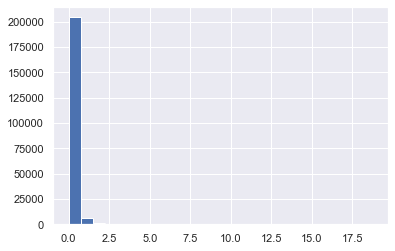

In [137]:
pre_prediction.item_cnt_month.hist(bins = 25)

In [138]:
pre_prediction[['ID', 'item_cnt_month']].to_csv('miguel_prediction.csv',index = False, header = True)

This result got 1.053 (best)

##### probing

In [139]:
all_combinations = daily_train.groupby(['item_id','shop_id']).agg(count = ('item_cnt_day','count')).reset_index()
all_combinations['Found'] = True

In [140]:
df_go = pre_prediction.merge(all_combinations, on = ['item_id','shop_id'], how = 'left')
df_go['Found'] = df_go['Found'].fillna(False)

In [141]:
df_go.groupby('Found').agg(count = ('ID','count'))

,count
Found,
False,102729
True,111471


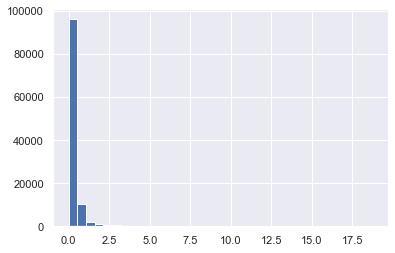

In [142]:
df_go[df_go.Found == True].item_cnt_month.hist(bins = 35)

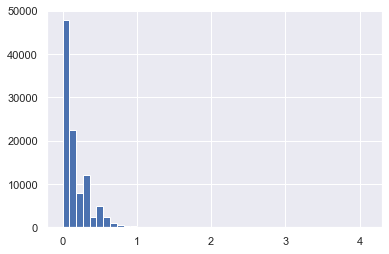

In [143]:
df_go[df_go.Found == False].item_cnt_month.hist(bins = 45)

In [144]:
df_go[df_go.Found == False].item_cnt_month.min()

0.0

In [145]:
def interval_corrector(data, interval, sample, value):
    data_part = data[(data.Found  == False) & (data.item_cnt_month >= interval[0]) & (data.item_cnt_month <= interval[1])].sample(frac = sample)
    data_part['flag'] = 1
    data = data.merge(data_part[['item_id','shop_id','flag']], on = ['item_id','shop_id'], how = 'left')
    data['item_cnt_month'] = np.where(data['flag'] == 1, value, data['item_cnt_month'])
    data = data.drop(columns = ['flag'])
    data = data.sort_values('ID')
    return data

In [146]:
df_go_mod = interval_corrector(data = df_go, interval = [0.9, 1.10], sample = 0.70, value = 0.35)

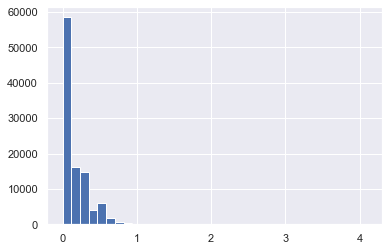

In [147]:
df_go_mod[df_go_mod.Found == False].item_cnt_month.hist(bins = 35)

In [170]:
df_go_mod[['ID','item_cnt_month']].to_csv('miguel_prediction_prov.csv',index = False, header = True)

this probing gor 1.21, then